In [33]:
from IPython.display import display
from docplex.mp.model import Model
from time import time
import os
import numpy as np
import math as math
import pandas as pd
import random
import warnings
import skr as skr
import networkx as nx
import matplotlib.pyplot as plt
import time as tm
warnings.filterwarnings("ignore")

In [34]:
from PIL import Image, ImageDraw, ImageFont

def drawing_scheduling(f_aph):

    Tx = {(n,x): [] for x in range(1, max_dev_node + 1) for n in aux_N}
    Rx = {(n,y): [] for y in range(1, max_dev_node + 1) for n in aux_N}
    
    for idx in f_aph.keys():
        if f_aph[idx] == 1:
            color = "#{:02x}{:02x}{:02x}".format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            Tx[(idx[0],idx[2])].append((idx[4][0],idx[4][1],color))
            Rx[(idx[1],idx[3])].append((idx[4][0],idx[4][1],color))

    # Set the size of each rectangle
    rectangle_size = (1500, 75*len(aux_N)*max(len(X), len(Y)))
    
    # Create an image with a white background
    image_size = (rectangle_size[0], rectangle_size[1])
    image = Image.new("RGB", image_size, "white")
    draw = ImageDraw.Draw(image)

    # Draw text in the first, second and third column
    column_1 = "Node"
    column_2 = "QKD Tx"
    column_3 = "QKD Rx"
    position_column_1 = (25,0)
    position_column_2 = (350,0)
    position_column_3 = (1075,0)
    
    
    # Define font size and load the font
    font_size = 15  # Adjust font size as needed
    font = ImageFont.load_default(font_size)

    # Draw text in the first, second and third column with increased font size
    draw.text(position_column_1, column_1, font=font, fill="black")
    draw.text(position_column_2, column_2, font=font, fill="green")
    draw.text(position_column_3, column_3, font=font, fill="red")

    y_start = 0
    for n in aux_N:
        for idx in range(1,max_dev_node + 1):

            # Draw black lines surrounding subrectangles
            draw.rectangle([80, y_start + 20, 720, y_start + 60], outline="black", width=2)  
            draw.rectangle([780, y_start + 20, 1420, y_start + 60], outline="black", width=2)
            
            # Draw text of nodes
            text_position = (position_column_1[0] + 5, y_start + 25)
            draw.text(text_position, f"{n}.{idx}",font=font, fill="black")
            text_position = (740, y_start + 25)
            draw.text(text_position, f"{n}.{idx}",font=font, fill="black")

            y_start += 70 
            

        draw.line([0, y_start + 10,1500, y_start + 10], fill="black", width=1) 

    y_start = 0
    # Draw rectangles with names and labels
    for n in aux_N:
        for x in range(1,max_dev_node + 1):
            if len(Tx[(n,x)]) != 0:
                for it in Tx[(n,x)]:
                    rectangle_x_start_left = 80 + 640*it[0]
                    rectangle_y_start_left = y_start + 20 
                    rectangle_x_end_left = rectangle_x_start_left + 640*(it[1] - it[0])
                    rectangle_y_end_left = y_start + 60
                    draw.rectangle([rectangle_x_start_left, rectangle_y_start_left, rectangle_x_end_left, rectangle_y_end_left], fill=it[2], outline="black", width=2)
                    draw.text((rectangle_x_start_left, rectangle_y_end_left +5), f"{it[0]}", fill="black")
                    draw.text((rectangle_x_end_left, rectangle_y_start_left -10), f"{it[1]}", fill="black")
            y_start += 70

    y_start = 0
    for n in aux_N:    
        for y in range(1,max_dev_node + 1):
            if len(Rx[(n,y)]) != 0:
                for it in Rx[(n,y)]:
                    rectangle_x_start_right = 780 + 640*it[0]
                    rectangle_y_start_right = y_start + 20  
                    rectangle_x_end_right = rectangle_x_start_right + 640*(it[1] - it[0])
                    rectangle_y_end_right = y_start + 60
                    draw.rectangle([rectangle_x_start_right, rectangle_y_start_right, rectangle_x_end_right, rectangle_y_end_right], fill=it[2], outline="black", width=2)
                    draw.text((rectangle_x_start_right, rectangle_y_end_right +5), f"{it[0]}", fill="black")
                    draw.text((rectangle_x_end_right, rectangle_y_start_right -10), f"{it[1]}", fill="black")
            y_start += 70                       
        
    # Display the image
    display(image)

Rows: 6, Columns: 6
Number of nodes = 6
N = {0, 1, 2, 3, 4, 5}
Number of edges = 6
E = [(0, 1), (1, 2), (1, 4), (2, 3), (3, 4), (3, 5)]
Longest distance in the network = 80 km
L = {(0, 1): 80, (1, 2): 32, (1, 4): 19, (2, 3): 16, (3, 4): 6, (3, 5): 70}
Maximum degree of the graph: 3
Average degree: 2.0


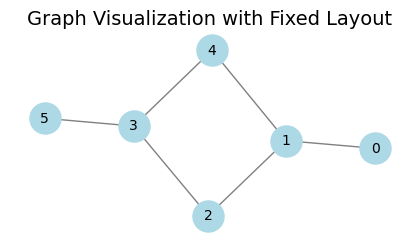

In [35]:
max_value_protocol = 80

# Load the CSV file
absolute_path = "/media/jc-user/My Box/Universidad Carlos III de Madrid/Coding/ONDM2025/network_topologies/"
data = pd.read_csv(absolute_path + "6_nodes_SECOQC.csv", header=None)

# Ensure the data has at least 700 rows and columns
print(f"Rows: {data.shape[0]}, Columns: {data.shape[1]}")

# Initialize the set N
N = set()

# Initialize the set E
E = []

# Initialize the set E
L = {}

# Iterate through rows and check
for index, row in data.iterrows():
    # Check if any value in the row is non-zero
    if (row != 0).any():
        N.add(index)
    
    # Check each column value in the current row
    for col_index, value in enumerate(row):
        if value != 0:
            if index < col_index:
                E.append((index, col_index))  # Add the (row, column) tuple to E
                L[(index, col_index)] = value  # Add the (row, column):value tuple to L

# Normalize values in L
max_value = max(L.values())  # Find the maximum value in L

# If the maximum value is greater than 0, normalize it
if max_value > max_value_protocol:
    scaling_factor = max_value_protocol / max_value
    L = {key: round(value * scaling_factor,4) for key, value in L.items()}  # Normalize each value


# Output network data
print("Number of nodes = " +str(len(N)))
print("N = " + str(N))
print("Number of edges = " +str(len(E)))
print("E = " + str(E))
print("Longest distance in the network = " +str(max(L.values())) + " km")
print("L = " + str(L))

# Create the graph
G = nx.Graph()
G.add_nodes_from(N)  # Add nodes
G.add_edges_from(E)  # Add edges

# Find the maximum degree
max_degree = max(dict(G.degree()).values())

print("Maximum degree of the graph:", max_degree)

degrees = dict(G.degree())
avg_degree_calc = sum(degrees.values()) / len(degrees)
print("Average degree:", avg_degree_calc)


# Generate fixed positions
fixed_pos = nx.spring_layout(G, seed=42)  # Use a random seed for consistent layout

# Draw the graph with fixed positions
plt.figure(figsize=(4, 2))
nx.draw(
    G, 
    fixed_pos, 
    with_labels=True, 
    node_color="lightblue", 
    edge_color="gray", 
    node_size=500, 
    font_size=10
)
plt.title("Graph Visualization with Fixed Layout", fontsize=14)
plt.show() 


In [ ]:
print("This code is made for Heuristic-Aided Relaxed MILP-Based Scheduler for QKDN (HAR-MBSQ)")
print("------------------------------------")
print(" ")

#Initializing timing
time_0 = time()

MBSQ_solution = {}

##########-------------------->>>>>>>>>> TOPOLOGIES <<<<<<<<<<---------------------##########
#Initializing variables and sets
SKR_nTDM = {}   #SKR for non TDM QChs  
SKR_TDM = {}    #SKR for switched TDM QChs (worst case, two switches in the QCh)

T = 3600    #Time period for TDM cycle
ts = 360    #Time for switching and recalibration, inherent to QKD devices technology

tf = {edge: 0 for edge in E} #Traffic matrix

#Computing the maximum number of slots 
if T/ts == np.floor(T/ts):
        d_max = T/ts - 1
else:
        d_max = int(np.floor(T/ts))

d_max = int(d_max)

#Computing the SKR for non TDM QChs and TDM QChs
for key, value in L.items():
    SKR_nTDM[key] = skr.compute_skr(value,0,256)
    SKR_TDM[key] = skr.compute_skr(value,2.4,256)

aux_N = N
aux_E = E

mean_skr = np.mean(list(SKR_nTDM.values()))

#Setting the values to start the iteration
N = aux_N
E = aux_E

G = nx.Graph()
G.add_nodes_from(N)
G.add_edges_from(E)

#Creating the traffic matrix
tf = {(i,j): round(random.uniform(mean_skr*0.01,mean_skr)) for (i,j) in E}
print("Traffic matrix:" + str(tf))

def find_free_slots(blocked_slots):
        blocked_slots.sort()
        free_slots = []
        current_start = 0

        for start, end in blocked_slots:
                if start > current_start:
                        free_slots.append((current_start, start))
                current_start = max(current_start, end)
        
        if current_start < 1:
                free_slots.append((current_start, 1))

        return free_slots
        
def node_scheduling(edges, dx_aux, dy_aux, blocked_slots_x, blocked_slots_y, schedule, solution):

        Tx = []
        Rx = []

        for (i,j) in edges:
                if i not in Tx:
                        Tx.append(i)
                if j not in Rx:
                        Rx.append(j)
                
        available_slots_x = {}
        for n in Tx:
                for x in X[n]:
                        available_slots_x[(n,x)] = find_free_slots(blocked_slots_x[(n,x)])
                        
        available_slots_y = {}
        for n in Rx:
                for y in Y[n]:
                        available_slots_y[(n,y)] = find_free_slots(blocked_slots_y[(n,y)])

        # In case a device is full, filter the possible values for X and Y

        # Rebuild X
        fil_X = {}
        for n in Tx:
                fil_X[n] = [x for x in X[n] if len(available_slots_x.get((n, x), [])) > 0]

        # Rebuild Y
        fil_Y = {}
        for n in Rx:
                fil_Y[n] = [y for y in Y[n] if len(available_slots_y.get((n, y), [])) > 0]                          
        
        aux_1 = []
        for n in Tx:
                for x in fil_X[n]:
                        for k in K:
                                for ng in Rx:
                                        for y in fil_Y[ng]:
                                                for k_p in K:
                                                        aux_1.append((n,ng,x,y,k,k_p))                
        aux_2_1 = []
        for n in Tx:
                for x in fil_X[n]:
                        aux_2_1.append((n,x,0))
                        for k in K:
                                aux_2_1.append((n,x,k))

        aux_2_2 = []            
        for n in Rx:
                for y in fil_Y[n]:
                        aux_2_2.append((n,y,0))
                        for k_p in K:
                                aux_2_2.append((n,y,k_p))                        
                        
        aux_3_1 = [(n,x) for n in Tx for x in fil_X[n]]
        aux_3_2 = [(n,y) for n in Rx for y in fil_Y[n]]

        aux_4_1 = [(n,x,k,s) for n in Tx for x in fil_X[n] for k in K for s in range(0, len(available_slots_x[(n,x)]))]
        aux_4_2 = [(n,y,k_p,s_p) for n in Rx for y in fil_Y[n] for k_p in K for s_p in range(0, len(available_slots_y[(n,y)]))]


        m = Model(name='flexible relaxed')

        ##### Decision variable #####
        delta = m.continuous_var_dict(aux_1, name="delta", lb=0, ub=1)
        alpha = m.binary_var_dict(aux_1, name="alpha")

        tx = m.continuous_var_dict(aux_2_1, name="tx", lb=0, ub=1)
        ty = m.continuous_var_dict(aux_2_2, name="ty", lb=0, ub=1)

        dx = m.binary_var_dict(aux_3_1, name="dx")
        dy = m.binary_var_dict(aux_3_2, name="dy")

        z_x = m.binary_var_dict(aux_4_1,name='z_x')
        z_y = m.binary_var_dict(aux_4_2,name='z_y')
        
        # #### Objective function #####        
        m.minimize(m.sum(0.5*dx[(n,x)] for n in Tx for x in fil_X[n]) + m.sum(dy[(n,y)] for n in Rx for y in fil_Y[n]))

        ##### Preliminary Constraints #####
        for n in Tx:
                for x in fil_X[n]:
                        if dx_aux[(n,x)] == 1:
                                m.add_constraint(dx[(n,x)] == 1)
                        if len(available_slots_x[(n,x)]) > 0:
                                for k in K:
                                        for s in range(0, len(available_slots_x[(n,x)])):
                                                start = available_slots_x[(n,x)][s][0]
                                                end = available_slots_x[(n,x)][s][1]
                                                m.add_constraint(tx[(n,x,k)] >= start + m.sum((alpha[(i,j,x,y,k,k_p)]*(ts/T) + delta[(i,j,x,y,k,k_p)]) for (i,j) in edges if i == n for y in fil_Y[j] for k_p in K) - (1 - z_x[(n,x,k,s)]))
                                                m.add_constraint(tx[(n,x,k)] <= end + (1 - z_x[(n,x,k,s)]))
                                        m.add_constraint(m.sum(z_x[(n,x,k,s)] for s in range(0, len(available_slots_x[(n,x)]))) == 1)
                                        
        for n in Rx:
                for y in fil_Y[n]:
                        if dy_aux[(n,y)] == 1:
                                m.add_constraint(dy[(n,y)] == 1)
                        if len(available_slots_y[(n,y)]) > 0:
                                for k_p in K:
                                        for s_p in range(0, len(available_slots_y[(n,y)])):
                                                start = available_slots_y[(n,y)][s_p][0]
                                                end = available_slots_y[(n,y)][s_p][1]
                                                m.add_constraint(ty[(n,y,k_p)] >= start + m.sum((alpha[(i,j,x,y,k,k_p)]*(ts/T) + delta[(i,j,x,y,k,k_p)]) for (i,j) in edges if j == n for x in fil_X[i] for k in K) - (1 - z_y[(n,y,k_p,s_p)]))
                                                m.add_constraint(ty[(n,y,k_p)] <= end + (1 - z_y[(n,y,k_p,s_p)]))
                                        m.add_constraint(m.sum(z_y[(n,y,k_p,s_p)] for s_p in range(0, len(available_slots_y[(n,y)]))) == 1)

        ##### Constraints #####
        for (i,j) in edges:
                m.add_constraint(tf[(i,j)] - 
                                m.sum(delta[(i,j,x,y,k,k_p)] for y in fil_Y[j] for x in fil_X[i] for k in K for k_p in K) <= 0)

        for n in Tx:
                for x in fil_X[n]:
                        for k in K:
                                for ng in Rx:
                                        for y in fil_Y[ng]:
                                                for k_p in K:
                                                        m.add_constraint(delta[(n,ng,x,y,k,k_p)] - alpha[(n,ng,x,y,k,k_p)] <= 0)

        for n in Tx:
                for x in fil_X[n]:
                        for k in K:
                                m.add_constraint(m.sum(alpha[(n,ng,x,y,k,k_p)] for ng in Rx for y in fil_Y[ng] for k_p in K) - 1 <= 0)

        for n in Rx:
                for y in fil_Y[n]:
                        for k_p in K:
                                m.add_constraint(m.sum(alpha[(ng,n,x,y,k,k_p)] for ng in Tx for x in fil_X[ng] for k in K) - 1 <= 0)

        for n in Tx:
                for x in fil_X[n]:
                        m.add_constraint(tx[(n,x,0)] <= 0)
                        for k in K:                        
                                m.add_constraint(tx[(n,x,k-1)] + 
                                                m.sum((alpha[(n,ng,x,y,k,k_p)]*(ts/T) + delta[(n,ng,x,y,k,k_p)]) 
                                                for ng in Rx for y in fil_Y[ng] for k_p in K) - tx[(n,x,k)] <= 0)
                                
        for n in Rx:
                for y in fil_Y[n]:
                        m.add_constraint(ty[(n,y,0)] <= 0)
                        for k_p in K:
                                m.add_constraint(ty[(n,y,k_p-1)] + 
                                                m.sum((alpha[(ng,n,x,y,k,k_p)]*(ts/T) + delta[(ng,n,x,y,k,k_p)]) 
                                                for ng in Tx for x in fil_X[ng] for k in K) - ty[(n,y,k_p)] <= 0)

        for n in Tx:
                for x in fil_X[n]:
                        for k in K:
                                for ng in Rx:
                                        for y in fil_Y[ng]:
                                                for k_p in K:
                                                        m.add_indicator(alpha[(n,ng,x,y,k,k_p)], tx[(n,x,k)] - ty[(ng,y,k_p)] == 0, 1)

        for n in Tx:
                for x in fil_X[n]:
                        m.add_constraint(m.sum(alpha[(n,ng,x,y,k,k_p)] for ng in Rx for y in fil_Y[ng] for k in K for k_p in K) - d_max*dx[(n,x)] <= 0)

        for n in Rx:
                for y in fil_Y[n]:
                        m.add_constraint(m.sum(alpha[(ng,n,x,y,k,k_p)] for ng in Tx for x in fil_X[ng] for k in K for k_p in K) - d_max*dy[(n,y)] <= 0)

        # Solve the model
        m.parameters.timelimit = 300
        sol = m.solve(log_output=False)
        #sol.display()
        if sol is None:
                solution = False
                print("No solution")

        else: 

                for (i,j) in edges: 
                        for x in fil_X[i]: 
                                flag_i_x = True
                                for y in fil_Y[j]:
                                        flag_j_y = True
                                        for k in K:
                                                for k_p in K:
                                                        if round(delta[(i,j,x,y,k,k_p)].solution_value,3) > 0:
                                                                lower_bound = abs(round(max(tx[(i,x,k)].solution_value, ty[(j,y,k_p)].solution_value) - ts/T - delta[(i,j,x,y,k,k_p)].solution_value,3))
                                                                upper_bound = round(max(tx[(i,x,k)].solution_value, ty[(j,y,k_p)].solution_value),3)
                                                                
                                                                schedule[(i,j,x,y,(lower_bound, upper_bound))] = 1
                                                                blocked_slots_x[(i,x)].append((lower_bound,upper_bound))
                                                                blocked_slots_y[(j,y)].append((lower_bound,upper_bound))
                                                                dx_aux[(i,x)] = dx[(i,x)].solution_value
                                                                dy_aux[(j,y)] = dy[(j,y)].solution_value

                                                                        

        return (dx_aux, dy_aux, blocked_slots_x, blocked_slots_y, schedule, solution)

#Removing the entire part of the rate Demand/Capacity, this may lead to a different network topo 
aux1 = {}
aux2 = []
direct_pairs = {(i,j): 0 for (i,j) in E}    #The number of non TDM QChs for links
for (i,j) in E:
        #Computing the remainder of non TDM QChs
        remainder_nTDM = round(tf[(i,j)]/SKR_nTDM[(i,j)] - np.floor(tf[(i,j)]/SKR_nTDM[(i,j)]),3)

        #Checking if the remainder using a SKR for TDM plus the contribution of switching is viable to by shared 
        if (SKR_nTDM[(i,j)]/SKR_TDM[(i,j)])*remainder_nTDM + ts/T  > 1:
                direct_pairs[(i,j)] = np.ceil(tf[(i,j)]/SKR_nTDM[(i,j)])     
        
        #If so, then update the corresponding values 
        else:
                aux1[(i,j)] = (SKR_nTDM[(i,j)]/SKR_TDM[(i,j)])*remainder_nTDM
                aux2.append((i,j))
                direct_pairs[(i,j)] = np.floor(tf[(i,j)]/SKR_nTDM[(i,j)])

print("Non swiched QTx-QRx pairs = " + str(direct_pairs))

#Updating the main sets 
tf = aux1.copy()
E = aux2
N = [n for n in N if n in [element for (i,j) in E for element in (i,j)]]

#Build the resulted topo
G = nx.Graph()
G.add_nodes_from(N)
G.add_edges_from(E)

capacity_installed = {}
saturation_degree = {n: 0 for n in N}

# Adjusting the parameters
max_iter = 10000  # Increase the maximum number of iterations
tol = 1e-06  # Decrease the tolerance level
nstart = {n: 1.0 for n in G.nodes()}  # Provide an initial guess

eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=max_iter, tol=tol, nstart=nstart)

uncolored = [k for k, v in sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True)]

while uncolored:
        if len(capacity_installed) == 0:
                # Choose the vertex with the highest degree initially
                n = max(uncolored)
        else:
                # Choose the vertex with the highest saturation degree, breaking ties by eigenvector_centrality
                n = max(uncolored, key=lambda x: (saturation_degree[x], eigenvector_centrality[x]))

        # Determine the smallest color not used by the neighbors of n
        neighbor_colors = [capacity_installed[ng] for ng in G.neighbors(n) if ng in capacity_installed]
        for col in [0,1]:
                if col not in neighbor_colors:
                        capacity_installed[n] = col
                        break

        if n not in capacity_installed:
                capacity_installed[n] = 2

        uncolored.remove(n)
        # Update the saturation degrees of the neighbors of n
        for ng in G.neighbors(n):
                if ng in uncolored:
                        unique_colors = [capacity_installed[n] for n in G.neighbors(ng) if n in capacity_installed]
                        saturation_degree[ng] = len(unique_colors)

Tx = [n for n in N if capacity_installed[n] in {0,2}]
Rx = [n for n in N if capacity_installed[n] in {1,2}]

Tx_copy = Tx.copy()
Rx_copy = Rx.copy()

# Rebuild E satisfying the conditions
E = [(n,ng) for n in N for ng in G.neighbors(n) 
        if capacity_installed[n] in {0,2} and capacity_installed[ng] in {1,2}]

new_tf = {(i,j):0 for (i,j) in E}
for (i,j), value in tf.items():
        # Check if the key or its reverse is in pairs_list
        if (i,j) in E:
                new_tf[(i,j)] = value
        elif (j,i) in E:
                new_tf[(j,i)] = value  # Reverse the ke
tf = new_tf.copy()

G = nx.Graph()
G.add_nodes_from(N)
G.add_edges_from(E)

max_dev_node_x = {n: sum(1 for ng in G.neighbors(n)) for n in Tx}
max_dev_node_y = {n: sum(1 for ng in G.neighbors(n)) for n in Rx}

K = np.arange(1, d_max + 1)
        
X = {n: np.arange(1,max_dev_node_x[n] + 1) for n in Tx}  
        
Y = {n: np.arange(1,max_dev_node_y[n] + 1) for n in Rx}

X_copy = X.copy()
Y_copy = Y.copy()

# Find the maximum values in X and Y
if len(tf.values()) == 0:
        max_value_X = 0
        max_value_Y = 0
else:
        max_value_X = max([np.max(values) for values in X.values() if len(values) != 0])
        max_value_Y = max([np.max(values) for values in Y.values() if len(values) != 0])

# Determine the overall maximum value
max_dev_node = max(max_value_X, max_value_Y)

# Adjusting the parameters
max_iter = 10000  # Increase the maximum number of iterations
tol = 1e-06  # Decrease the tolerance level
nstart = {n: 1.0 for n in G.nodes()}  # Provide an initial guess
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=max_iter, tol=tol, nstart=nstart)

total_node_demand = {n: 0 for n in G.nodes()}

for (u,v), value in tf.items():
        total_node_demand[u] += value
        total_node_demand[v] += value

score = {n: (total_node_demand[n]*eigenvector_centrality[n]) for n in N}

unvisited = [k for k, v in sorted(score.items(), key=lambda item: item[1], reverse=True)]
visited_edges = []

blocked_slots_x = {(n,x): [] for n in Tx for x in X[n]}
blocked_slots_y = {(n,y): [] for n in Rx for y in Y[n]}
schedule = {}

dx = {(n,x): 0 for n in Tx for x in X[n]}
dy = {(n,y): 0 for n in Rx for y in Y[n]}

####### Main Loop ######
for n in unvisited:

        # Iterate over the neighbors of "n" and solve the scheduling for the max_degree_per_sim neighbours at time        
        if n in Tx:
                edges = [(i,j) for (i,j) in E if i==n and (i,j) not in visited_edges]
        else:
                edges = [(i,j) for (i,j) in E if j==n and (i,j) not in visited_edges]
        
        #Updating visited edges
        if len(edges) != 0:
                for (i,j) in edges:
                        visited_edges.append((i,j))

                result = node_scheduling(edges, dx, dy, blocked_slots_x, blocked_slots_y, schedule, solution=True)

                dx, dy, blocked_slots_x, blocked_slots_y, schedule, solution = result[0],result[1],result[2],result[3],result[4],result[5]

                if solution is False:
                        for (i,j) in E:
                                if (i,j) in direct_pairs.keys():
                                        direct_pairs[(i,j)] += np.ceil(tf[(i,j)])
                                else:
                                        direct_pairs[(j,i)] += np.ceil(tf[(j,i)])

                        dx = {(n,x): 0 for n in Tx for x in X[n]}
                        dy = {(n,y): 0 for n in Rx for y in Y[n]}
                        break
        
if sum(dx[(n,x)] for n in Tx for x in X[n]) < sum(dy[(n,y)] for n in Rx for y in Y[n]):
        Tx, Rx = Rx, Tx
        X, Y = Y, X
        dx, dy = dy.copy(), dx.copy()
        schedule = {(k[1], k[0], *k[2:]): v for k, v in schedule.items()}

time_f = time()                  

my_sol =(round(time_f - time_0,4),
        0,
        0.5*(sum(direct_pairs.values()) + sum(dx.values())) + (sum(direct_pairs.values()) + sum(dy.values())),
        2*sum(direct_pairs.values()) + sum(dx.values()) + sum(dy.values()),
        sum(direct_pairs.values()) + sum(dx.values()),
        sum(direct_pairs.values()) + sum(dy.values()))

print(f"Sol ==> Runtime: {my_sol[0]},Gap: {my_sol[1]},Cost: {my_sol[2]}, Total: {my_sol[3]}, Tx: {my_sol[4]}, Rx: {my_sol[5]}")
HAR_MBSQ_solution = my_sol
tm.sleep(5)
print(" ")

This code is made for Heuristic-Aided Relaxed MILP-Based Scheduler for QKDN (HAR-MBSQ)
------------------------------------
 
Traffic matrix:{(0, 1): 1860, (1, 2): 269, (1, 4): 1620, (2, 3): 758, (3, 4): 923, (3, 5): 620}
Non swiched QTx-QRx pairs = {(0, 1): 23.0, (1, 2): 0.0, (1, 4): 0.0, (2, 3): 0.0, (3, 4): 0.0, (3, 5): 3.0}
Sol ==> Runtime: 1.5914,Gap: 0,Cost: 45.0, Total: 60.0, Tx: 30.0, Rx: 30.0
 


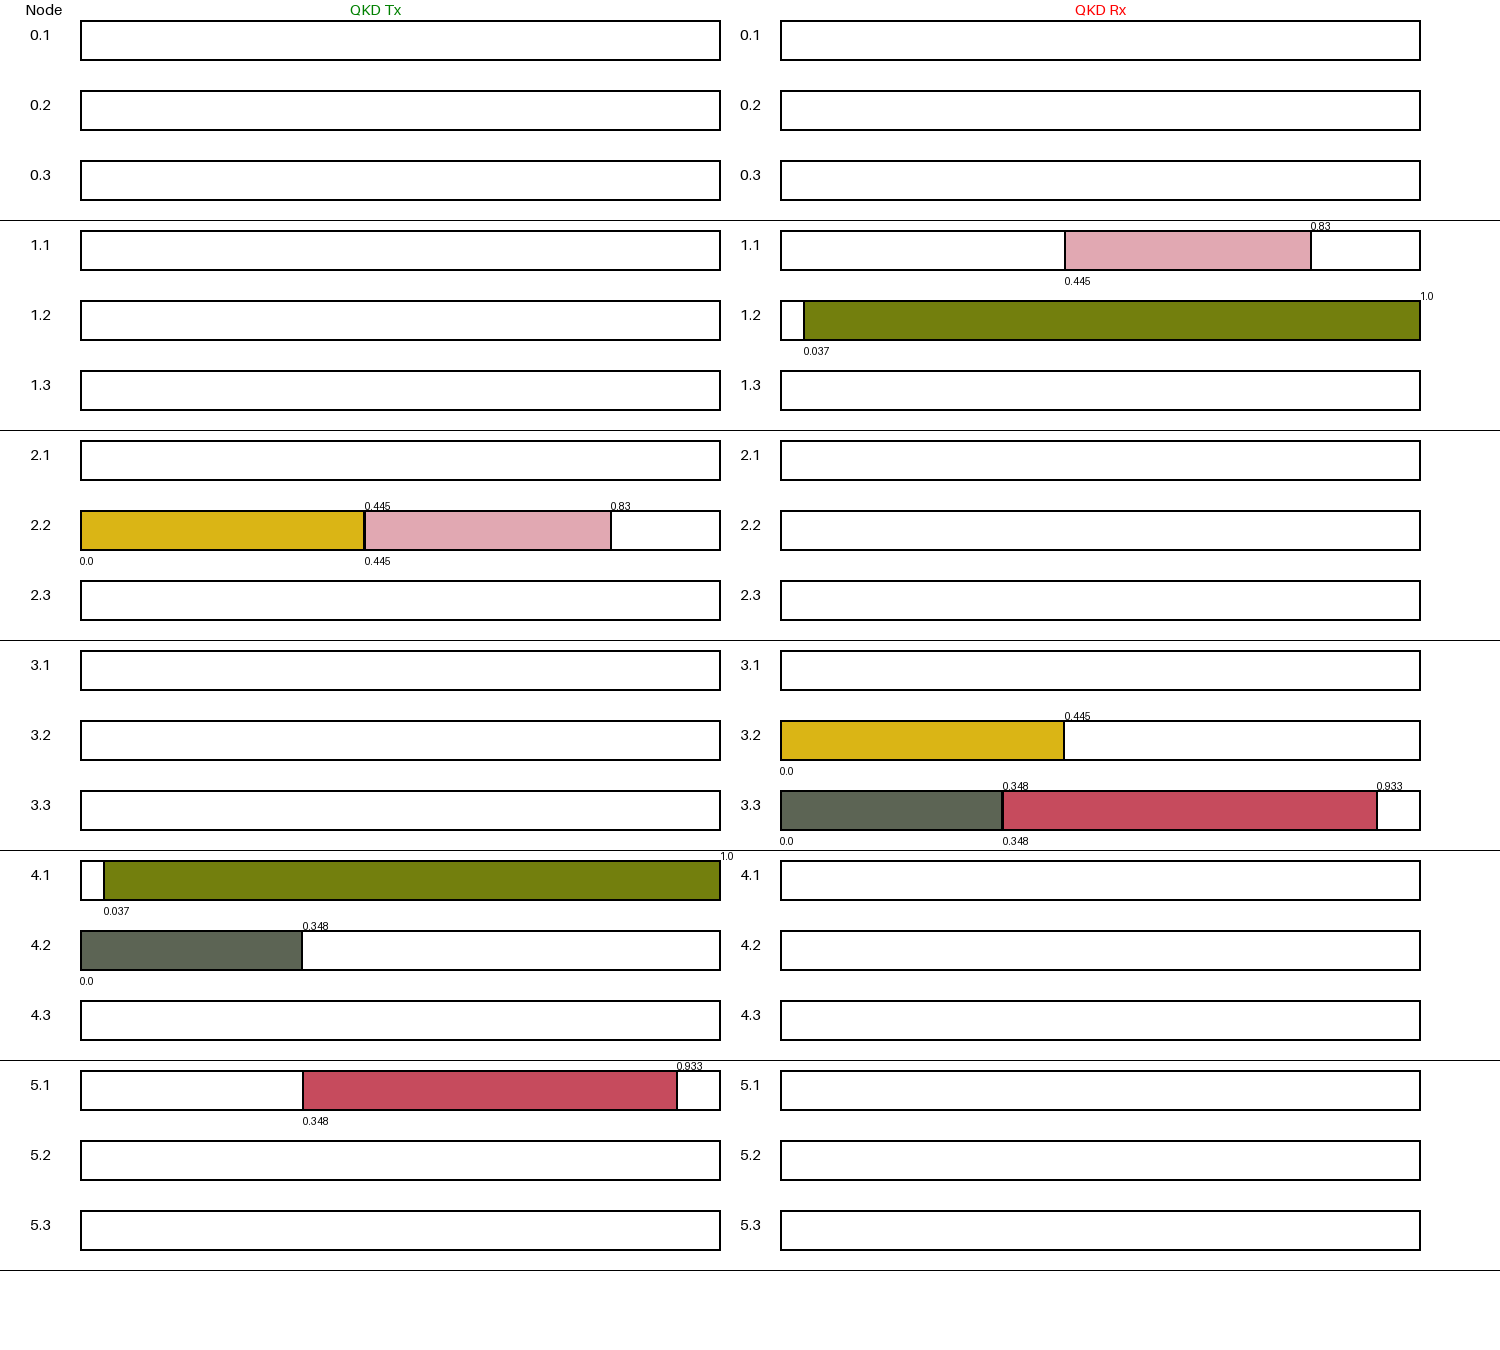

In [37]:
drawing_scheduling(schedule)